## PROJECT 36: Forecasting energy consumption for train traction

> ### TASK: To study various modern approaches and models to forecasting power consumption for train traction


### Stage goal

- **Create Naïve forecasting like baseline model**
- **Apply N-BEATS model for forecasting power consumption for train traction**
-**Compare results**


### IMPORT LIBRARIES

In [1]:
# !pip install -U statsmodels

# !pip install sktime

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('bmh')
import seaborn as sns
sns.set_style('darkgrid')

import statsmodels.api as sm

from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import MeanAbsoluteError, MeanSquaredError, MeanAbsolutePercentageError, MeanAbsoluteScaledError
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split



from sklearn.preprocessing import MinMaxScaler

from pandas import DataFrame
from pandas import concat

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Dropout, Dense, Input,  MaxPool1D, subtract, add
from tensorflow.keras.models import Model

### DATA PREPARATON

In [3]:
# Path to data
data_path ="/content/drive/MyDrive/Project_36_Forecasting_energy_consumption_for_train_traction/data/Raskhod_EP_24_03_2020.csv"

In [4]:
# Load the data
data_df = pd.read_csv(data_path, sep=';')

In [5]:
# Dictionary of variables
list_of_variables = {'Ввод подстанции' : 'entering_substation',
                     'Date' : 'date',
                     'Расход' : 'consumption',
                     'Макс.' : 'max_consumption'}   

# Re-assign variables
data_df = data_df.rename(columns = list_of_variables) 

data_df['date'] = pd.to_datetime(data_df['date'])

# Creating a multi-index
data_df = data_df.set_index(['date','entering_substation'])

# List of traction substations
data_df.index.levels[1].to_list()

['Бада - Ввод Т1 27.5 кВ',
 'Бада - Ввод Т2 27.5 кВ',
 'Белогорск - Ввод Т1 27.5 кВ',
 'Белогорск - Ввод Т2 27.5 кВ',
 'Бушулей - Ввод Т1 27.5 кВ',
 'Бушулей - Ввод Т2 27.5 кВ',
 'Завитая - Ввод Т1 27.5 кВ',
 'Завитая - Ввод Т2 27.5 кВ',
 'Зилово - Ввод Т1 27.5 кВ',
 'Зилово - Ввод Т3 27.5 кВ',
 'Карымская - Ввод Т1 27.5 кВ',
 'Карымская - Ввод Т2 27.5 кВ',
 'Карымская - Ввод Т6 27.5 кВ',
 'Магдагачи - Ввод Т1 27.5 кВ',
 'Магдагачи - Ввод Т2 27.5 кВ',
 'Могзон - Ввод Т1 27.5 кВ',
 'Могзон - Ввод Т2 27.5 кВ',
 'Могоча - Ввод Т1 27.5 кВ',
 'Могоча - Ввод Т2 27.5 кВ',
 'Новая - Ввод Т1 27.5 кВ',
 'Новая - Ввод Т2 27.5 кВ']

#### **As an example for further research and training of the model, we use the Belogorsk traction substation - Input T2 27.5 kV**

In [6]:
# Selection of traction substation
traction_substation_df = data_df.xs('Белогорск - Ввод Т2 27.5 кВ', level=1)['consumption']

# Removing duplicate values
traction_substation_df = traction_substation_df.drop_duplicates()

# Selection of the required subset of data
traction_substation_df = traction_substation_df.sort_index(level=[0]).loc['2017-01-01':'2019-12-31']

traction_substation_df.head()

date
2017-01-01    230640
2017-01-02    251133
2017-01-03    231118
2017-01-04    235054
2017-01-05    134475
Name: consumption, dtype: int64

### EVALUATION RESULT

In [7]:

# EVALUATION AND VISUALIZATION OF MODEL PARAMETERS
def learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(20, 8))
    plt.grid(True)
    plt.title('Learning curves')
    plt.gca().set_ylim(0, 1)
    plt.show()


def evaluation_model(history):
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(20, 8))
    axL.plot(history.history['loss'], label="Training loss")
    axL.plot(history.history['val_loss'], label="Validation loss")
    axL.set_title('Training and Validation loss')
    axL.set_xlabel('Epochs')
    axL.set_ylabel('Loss')
    axL.legend(loc='upper right')

    axR.plot(history.history['mae'], label="Training mae")
    axR.plot(history.history['val_mae'], label="Validation mae")
    axR.set_title('Training and Validation mae')
    axR.set_xlabel('Epoch')
    axR.set_ylabel('MAE')
    axR.legend(loc='upper right')

    plt.show()
    
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("People")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)
    
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)


def mean_absolute_scaled_error(y_true, y_pred):
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

    return mae / mae_naive_no_season


def evaluate_preds(y_true, y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
  
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

### Naïve forecast (baseline) $\hat{y}_{t}=y_{t-1}$



In [8]:
def plot_time_series(timesteps, values, format='-', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Consumption")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

In [9]:
split_size = int(0.8 * len(traction_substation_df)) 

timesteps = traction_substation_df.index.to_numpy()
consumption = traction_substation_df[:].to_numpy()

X_train, y_train = timesteps[:split_size], consumption[:split_size]

X_test, y_test = timesteps[split_size:], consumption[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(846, 212, 846, 212)

In [10]:
# Naïve forecast
naive_forecast = y_test[:-1]

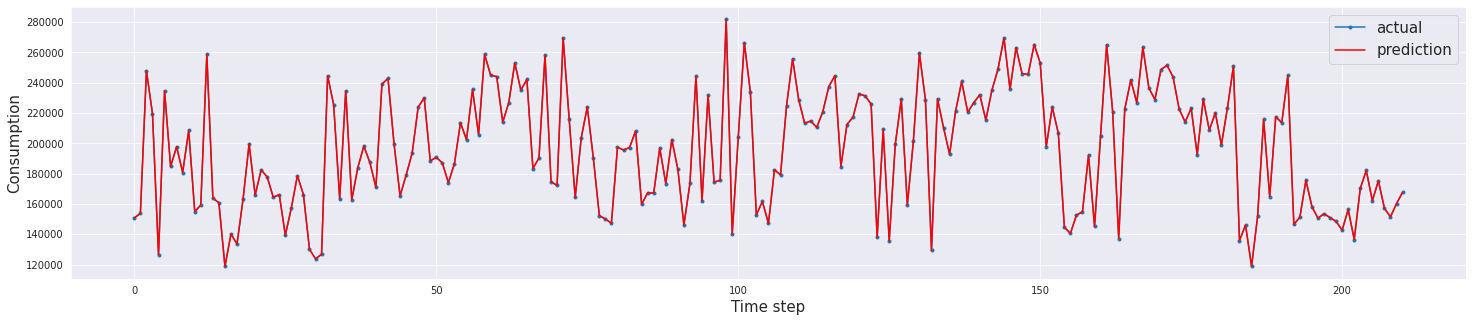

In [11]:
# Plot naive forecast
aa=[x for x in range(211)]
plt.figure(figsize=(25, 5))
plt.plot(aa, y_test[:211], marker='.', label="actual")
plt.plot(aa, naive_forecast[:211], 'r', label="prediction")
plt.ylabel('Consumption', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

In [12]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 31373.07,
 'mape': 16.718054,
 'mase': 0.9957199,
 'mse': 1794750500.0,
 'rmse': 42364.496}

## N-BEATS model

Transform the data into a time series problem

In [13]:
def series_to_supervised(data, n_in=7, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [14]:
values = traction_substation_df.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values.reshape(-1, 1))

data_df_norm = series_to_supervised(scaled, n_in=7, n_out=1, dropnan=True)
data_df_norm.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,0.757882,0.844805,0.759909,0.776604,0.349990,0.443572,0.402119,0.604680
8,0.844805,0.759909,0.776604,0.349990,0.443572,0.402119,0.604680,0.617337
9,0.759909,0.776604,0.349990,0.443572,0.402119,0.604680,0.617337,0.801388
10,0.776604,0.349990,0.443572,0.402119,0.604680,0.617337,0.801388,0.498441
11,0.349990,0.443572,0.402119,0.604680,0.617337,0.801388,0.498441,0.625875


In [15]:
values = data_df_norm.values

n_train_time = int(len(traction_substation_df)*0.8)

train = values[:n_train_time, :]
test = values[n_train_time:, :]

X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((846, 7), (205, 7), (846,), (205,))

### Create NBeatsBlock custom layer 

In [16]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]

    # Output of block is a theta layer
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)

    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

### Prepare data with `tf.data`


In [17]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

### Setting up hyperparameters for N-BEATS algorithm

In [18]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

HORIZON = 1 
WINDOW_SIZE = 7

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### N-BEATS 

In [19]:
# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)

# Add in subtraction residual link
residuals = subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}")(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_N_BEATS = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")


In [20]:
# Compile model
model_N_BEATS.compile(loss="mae",
                      optimizer=tf.keras.optimizers.Adam(0.001),
                      metrics=["mae", "mse"])

Model: "model_N-BEATS"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 stack_input (InputLayer)       [(None, 7)]          0           []                               
                                                                                                  
 InitialBlock (NBeatsBlock)     ((None, 7),          796168      ['stack_input[0][0]']            
                                 (None, 1))                                                       
                                                                                                  
 subtract_00 (Subtract)         (None, 7)            0           ['stack_input[0][0]',            
                                                                  'InitialBlock[0][0]']           
                                                                                      

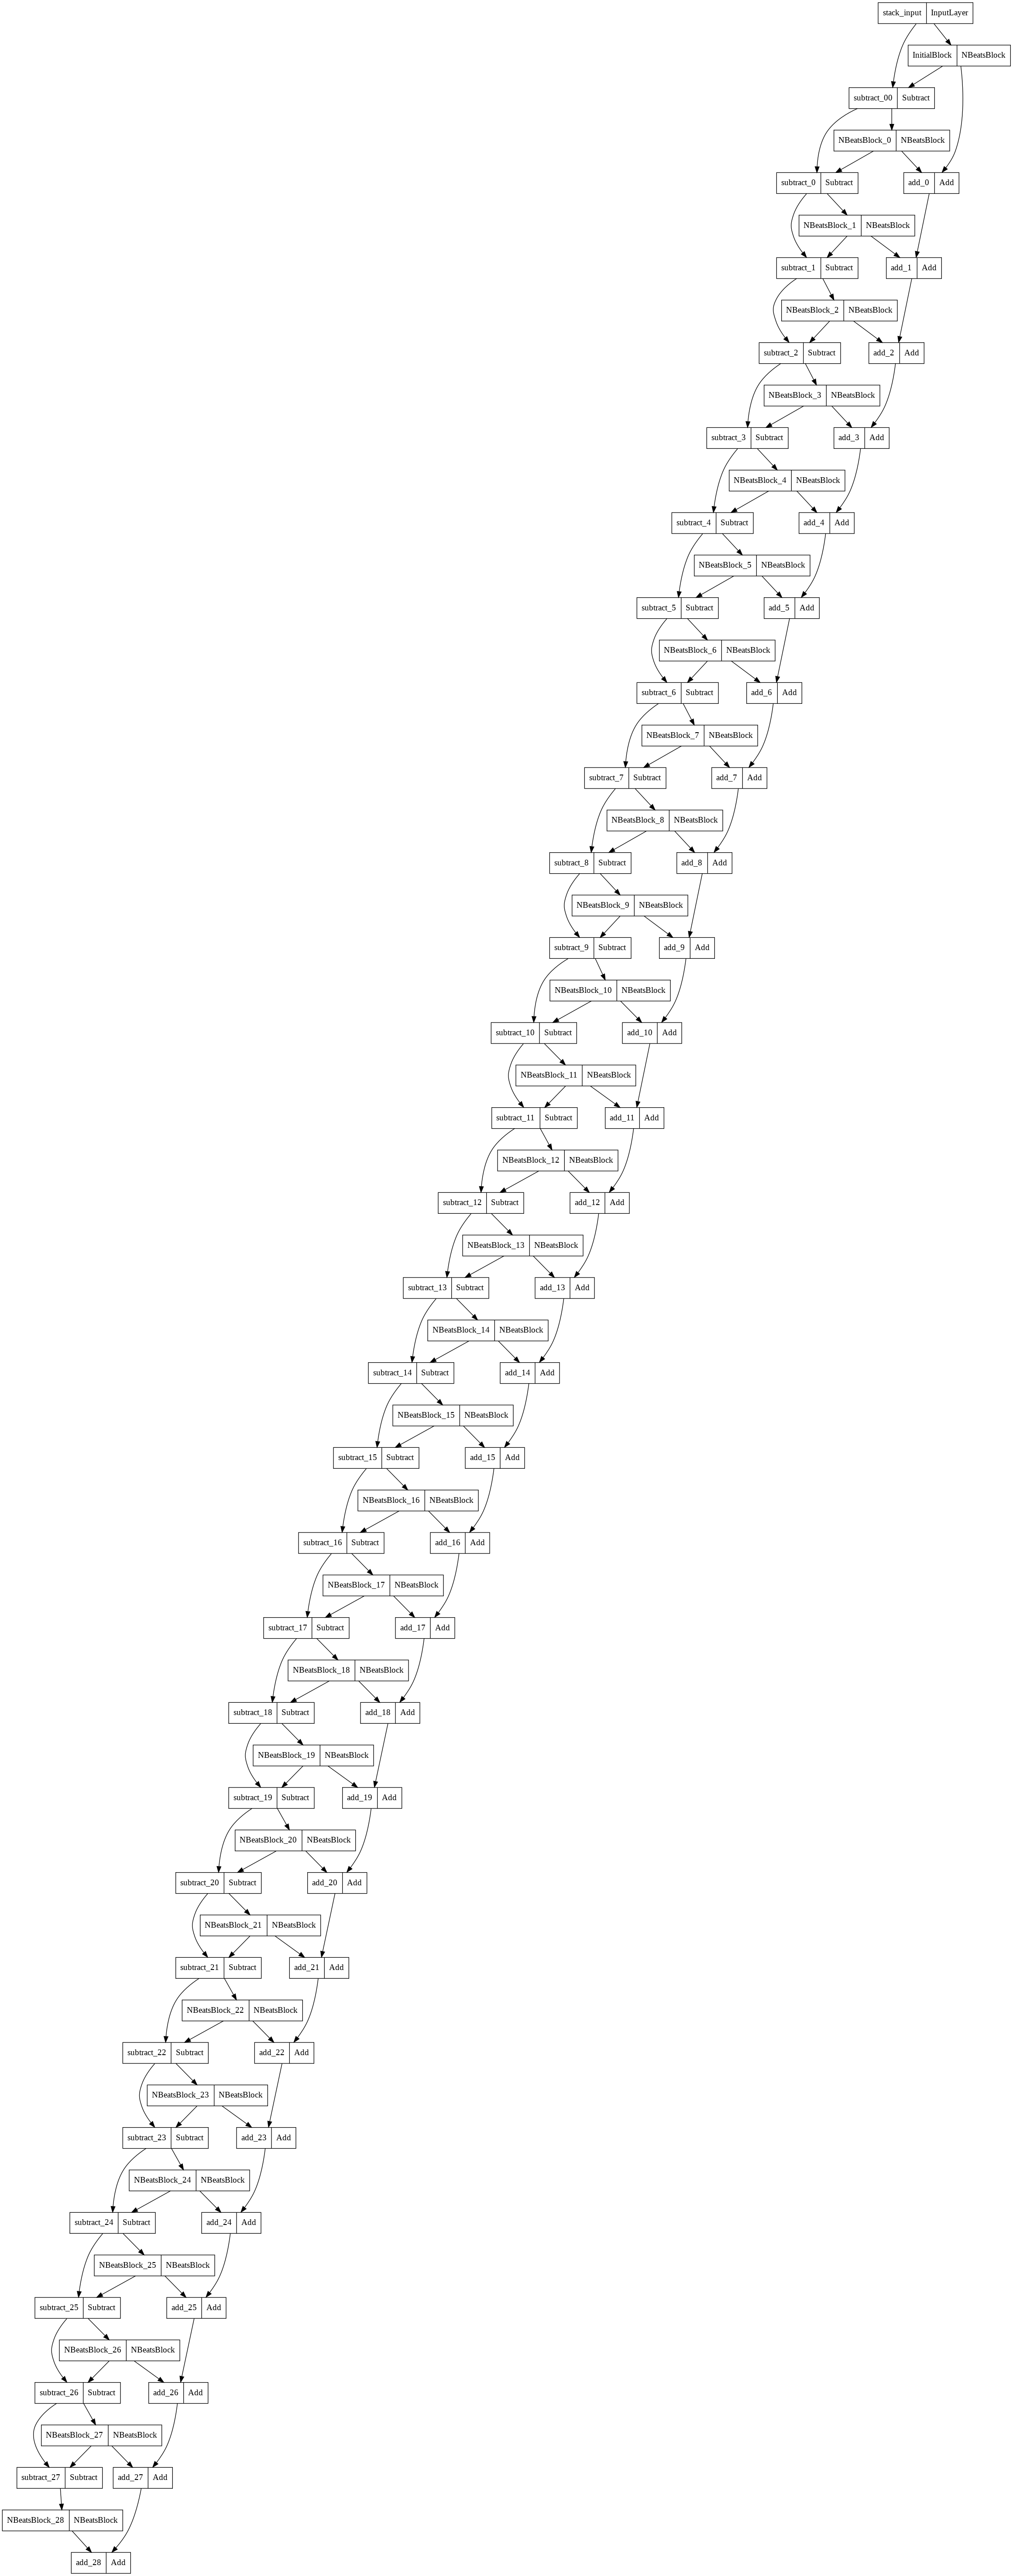

In [21]:
model_N_BEATS.summary()
tf.keras.utils.plot_model(model_N_BEATS, to_file='model_N_BEATS.png')

In [22]:
# Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_N_BEATS_history = model_N_BEATS.fit(train_dataset,
                                       epochs=N_EPOCHS,
                                       validation_data=test_dataset,
                                       verbose=2,
                                       callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

Epoch 1/5000
1/1 - 15s - loss: 0.7455 - mae: 0.7455 - mse: 0.6019 - val_loss: 9.5766 - val_mae: 9.5766 - val_mse: 94.0193 - lr: 0.0010 - 15s/epoch - 15s/step
Epoch 2/5000
1/1 - 3s - loss: 8.2397 - mae: 8.2397 - mse: 71.1303 - val_loss: 3.8301 - val_mae: 3.8301 - val_mse: 15.1928 - lr: 0.0010 - 3s/epoch - 3s/step
Epoch 3/5000
1/1 - 3s - loss: 3.6580 - mae: 3.6580 - mse: 14.1356 - val_loss: 1.2533 - val_mae: 1.2533 - val_mse: 1.6509 - lr: 0.0010 - 3s/epoch - 3s/step
Epoch 4/5000
1/1 - 3s - loss: 1.2230 - mae: 1.2230 - mse: 1.6219 - val_loss: 0.7978 - val_mae: 0.7978 - val_mse: 0.7419 - lr: 0.0010 - 3s/epoch - 3s/step
Epoch 5/5000
1/1 - 3s - loss: 0.9534 - mae: 0.9534 - mse: 1.0414 - val_loss: 0.2347 - val_mae: 0.2347 - val_mse: 0.0786 - lr: 0.0010 - 3s/epoch - 3s/step
Epoch 6/5000
1/1 - 3s - loss: 0.2792 - mae: 0.2792 - mse: 0.1076 - val_loss: 0.1697 - val_mae: 0.1697 - val_mse: 0.0432 - lr: 0.0010 - 3s/epoch - 3s/step
Epoch 7/5000
1/1 - 3s - loss: 0.1747 - mae: 0.1747 - mse: 0.0481 - va

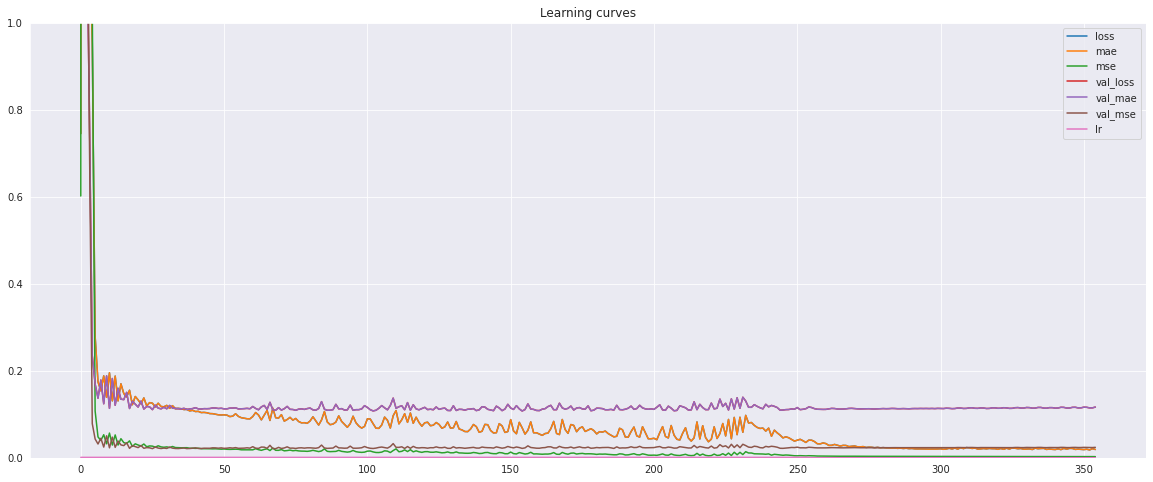

In [23]:
# Learning curves
learning_curves(model_N_BEATS_history)

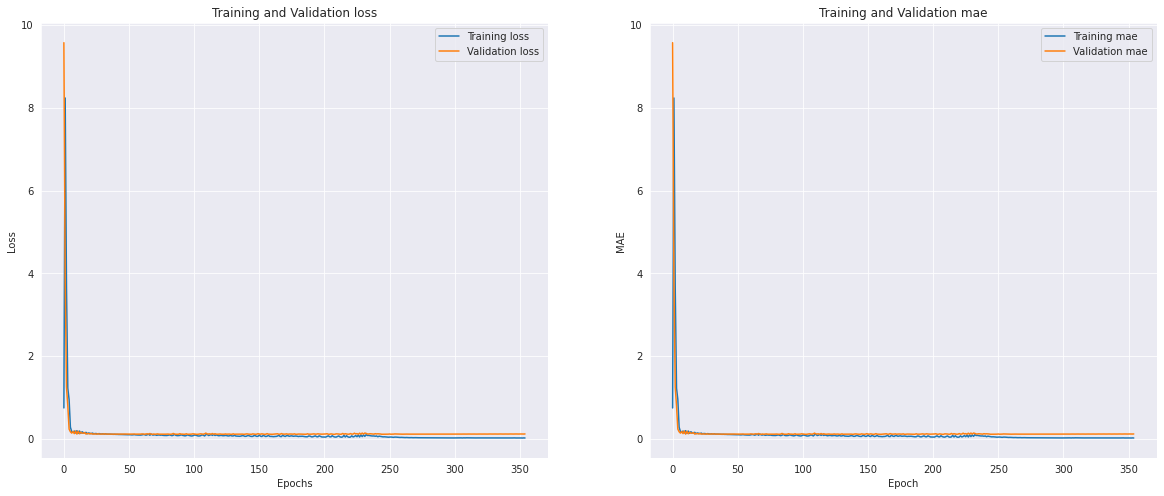

In [24]:
# Evaluation model
evaluation_model(model_N_BEATS_history)

In [25]:
# Evaluate model on test data
model_N_BEATS.evaluate(X_test, y_test)

7/7 [==============================] - 2s 61ms/step - loss: 0.1076 - mae: 0.1076 - mse: 0.0216


[0.1076468676328659, 0.1076468676328659, 0.021615685895085335]

In [26]:
# Make predictions
model_N_BEATS_preds = make_preds(model_N_BEATS, X_test)
model_N_BEATS_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.6333992 , 0.62151206, 0.6619756 , 0.63060844, 0.4408002 ,
       0.4340851 , 0.43500552, 0.42010653, 0.5081268 , 0.41588613],
      dtype=float32)>

In [27]:
# Evaluate predictions
model_N_BEATS_results = evaluate_preds(y_true=y_test,
                                       y_pred=model_N_BEATS_preds)
model_N_BEATS_results

{'mae': 0.10764686,
 'mape': 19.172869,
 'mase': 0.8310317,
 'mse': 0.02161569,
 'rmse': 0.14702275}

In [28]:
naive_results

{'mae': 31373.07,
 'mape': 16.718054,
 'mase': 0.9957199,
 'mse': 1794750500.0,
 'rmse': 42364.496}

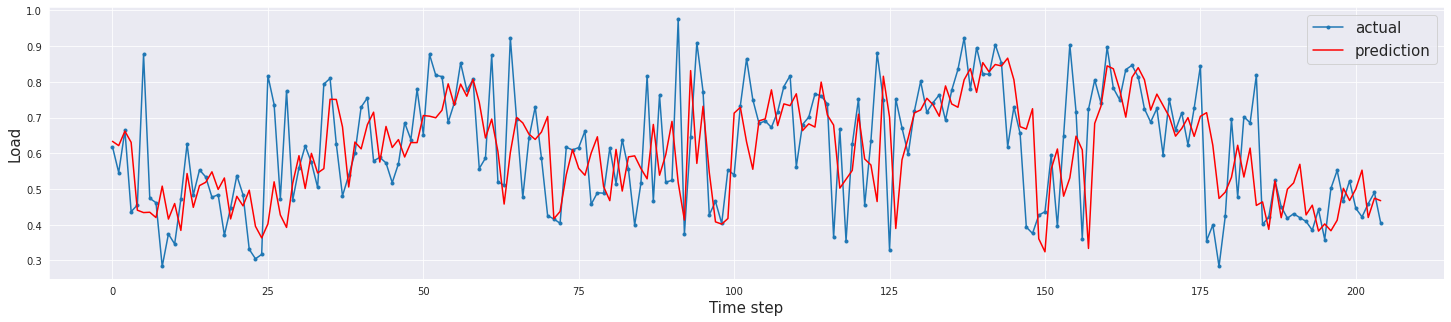

In [29]:
aa=[x for x in range(205)]
plt.figure(figsize=(25, 5))
plt.plot(aa, y_test[:205], marker='.', label="actual")
plt.plot(aa, model_N_BEATS_preds[:205], 'r', label="prediction")
plt.ylabel('Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

### Evaluation of results at another substation

Completely new data for the model.

In [30]:
# Selection of traction substation
traction_substation_df = data_df.xs('Могоча - Ввод Т1 27.5 кВ', level=1)['consumption']

# Removing duplicate values
traction_substation_df = traction_substation_df.drop_duplicates()

# Selection of the required subset of data
traction_substation_df = traction_substation_df.sort_index(level=[0]).loc['2017-01-01':'2019-12-31']

traction_substation_df.head()

date
2017-01-01    149220
2017-01-02    138779
2017-01-03     24379
2017-01-04     45312
2017-01-05     37397
Name: consumption, dtype: int64

In [39]:
values = traction_substation_df.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values.reshape(-1, 1))

data_df_norm = series_to_supervised(scaled, n_in=7, n_out=1, dropnan=True)
data_df_norm.shape

(776, 8)

In [40]:
values = data_df_norm.values

n_train_time = int(len(traction_substation_df)*0.8)

train = values[:n_train_time, :]
test = values[n_train_time:, :]

X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((626, 7), (150, 7), (626,), (150,))

In [42]:
# Evaluate model on test data
model_N_BEATS.evaluate(X_test, y_test)

5/5 [==============================] - 0s 60ms/step - loss: 0.1685 - mae: 0.1685 - mse: 0.0582


[0.16854196786880493, 0.16854196786880493, 0.05819780379533768]

In [43]:
# Make predictions
model_N_BEATS_preds = make_preds(model_N_BEATS, X_test)
model_N_BEATS_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.7456908 , 0.726361  , 0.8255094 , 0.70085603, 0.782555  ,
       0.8129562 , 0.83390504, 0.8296449 , 0.8198837 , 0.8038979 ],
      dtype=float32)>

In [44]:
# Evaluate predictions
model_N_BEATS_results = evaluate_preds(y_true=y_test,
                                       y_pred=model_N_BEATS_preds)
model_N_BEATS_results

{'mae': 0.16854197,
 'mape': 3081577.8,
 'mase': 0.8999557,
 'mse': 0.058197804,
 'rmse': 0.24124222}

In [45]:
naive_results

{'mae': 31373.07,
 'mape': 16.718054,
 'mase': 0.9957199,
 'mse': 1794750500.0,
 'rmse': 42364.496}

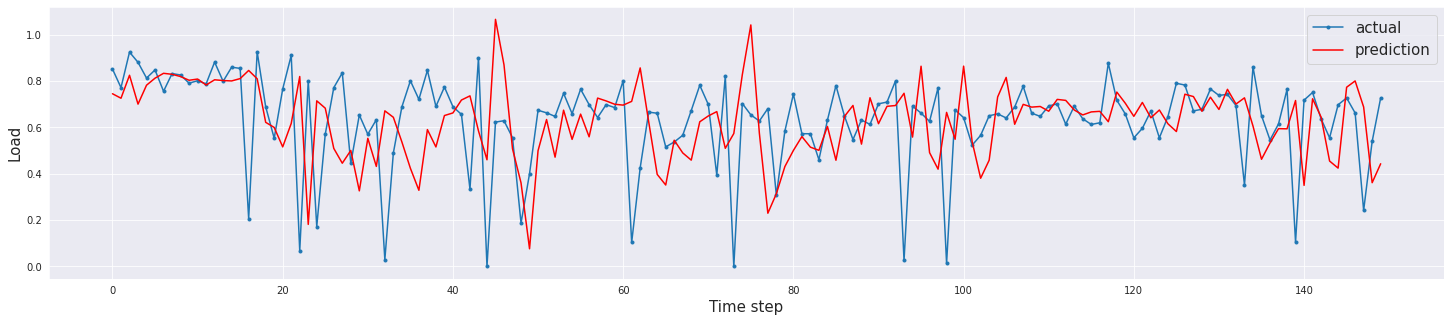

In [47]:
aa=[x for x in range(150)]
plt.figure(figsize=(25, 5))
plt.plot(aa, y_test[:150], marker='.', label="actual")
plt.plot(aa, model_N_BEATS_preds[:150], 'r', label="prediction")
plt.ylabel('Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()